In [1]:
import rasterio
import geopandas as gpd
import pandas as pd
from rasterstats import point_query
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import rioxarray as rio
import rasterio
import pystac_client
import planetary_computer
from odc.stac import stac_load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rioxarray as rio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import matplotlib.pyplot as plt


In [8]:
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bbox = [lower_left[1], lower_left[0], upper_right[1], upper_right[0]] 


time_window = "2023-06-01/2025-02-01"

In [13]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


search = stac.search(
    bbox=bbox,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}},
)


items = list(search.get_items())
print(f"Number of Sentinel-2 scenes found: {len(items)}")


signed_items = [planetary_computer.sign(item).to_dict() for item in items]

Number of Sentinel-2 scenes found: 63


In [10]:

resolution = 10  
scale = resolution / 111320.0  


data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "AOT", "WVP", "SCL","B09"],
    crs="EPSG:4326",  
    resolution=scale,  
    chunks={"df": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bbox
)

print(data)

<xarray.Dataset> Size: 4GB
Dimensions:      (latitude: 1448, longitude: 1671, time: 50)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 400B 2023-06-01T15:51:41.024000 ... 20...
Data variables: (12/15)
    B01          (time, latitude, longitude) uint16 242MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 242MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 242MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 242MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 242MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, lo

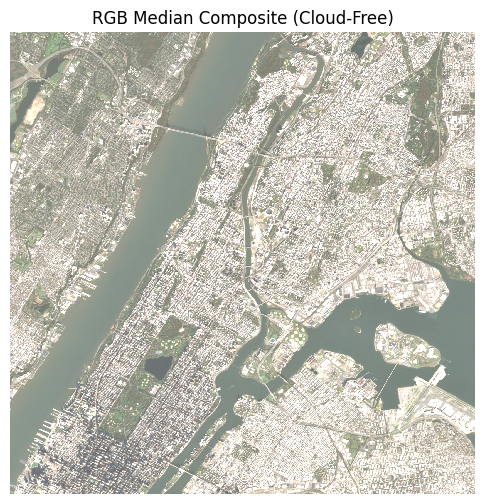

In [11]:
median = data.median(dim="time").compute()


fig, ax = plt.subplots(figsize=(6, 6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite (Cloud-Free)")
ax.axis('off')
plt.show()

In [16]:
filename = "Sentinel2_NYC69.tif"


height, width = median.dims["latitude"], median.dims["longitude"]
transform = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)

median.rio.write_crs("EPSG:4326", inplace=True)
median.rio.write_transform(transform, inplace=True)

with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                   crs="EPSG:4326", transform=transform,
                   count=len(median.data_vars), dtype="float32") as dst:
    for i, band in enumerate(median.data_vars.keys()):
        dst.write(median[band], i + 1)

print(f"GeoTIFF saved: {filename}")

GeoTIFF saved: Sentinel2_NYC69.tif
